In [2]:
import sys
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent))

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from data.synthetic import make_moons_dataset, split_and_standardize
from models.mlp import MLP
from optim.factory import OptimConfig, make_optimizer
from train.trainer import TrainConfig, train_classifier

torch.manual_seed(42)
np.random.seed(42)

device = "cpu"
X, y = make_moons_dataset(n_samples=4000, noise=0.25, seed=42, device=device)
X_tr, y_tr, X_val, y_val, scaler = split_and_standardize(X, y, test_size=0.2, seed=42)


In [4]:
def run_sgd_momentum(lr: float, momentum: float = 0.0, nesterov: bool = False, seed: int = 42):
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = MLP(in_dim=2, hidden_dim=128, out_dim=1, act="relu", use_he=True)

    opt_cfg = OptimConfig(
        name="sgd_momentum",
        lr=lr,
        momentum=momentum,
        nesterov=nesterov,
        weight_decay=0.0,
    )
    opt = make_optimizer(model.parameters(), opt_cfg)

    cfg = TrainConfig(
        steps=2000,
        batch_size=256,
        log_every=50,
        clip_norm=None,
        device=device,
    )

    hist = train_classifier(
        model=model,
        optimizer=opt,
        X_train=X_tr,
        y_train=y_tr,
        X_val=X_val,
        y_val=y_val,
        cfg=cfg,
    )
    return hist


In [5]:
lr = 1e-2


In [6]:
h_sgd = run_sgd_momentum(lr=lr, momentum=0.0, seed=42)
h_m09 = run_sgd_momentum(lr=lr, momentum=0.9, seed=42)
h_m95 = run_sgd_momentum(lr=lr, momentum=0.95, seed=42)
h_nes = run_sgd_momentum(lr=lr, momentum=0.9, nesterov=True, seed=42)


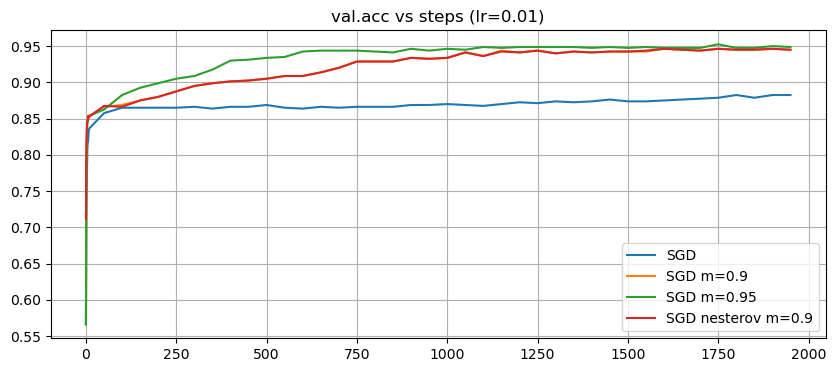

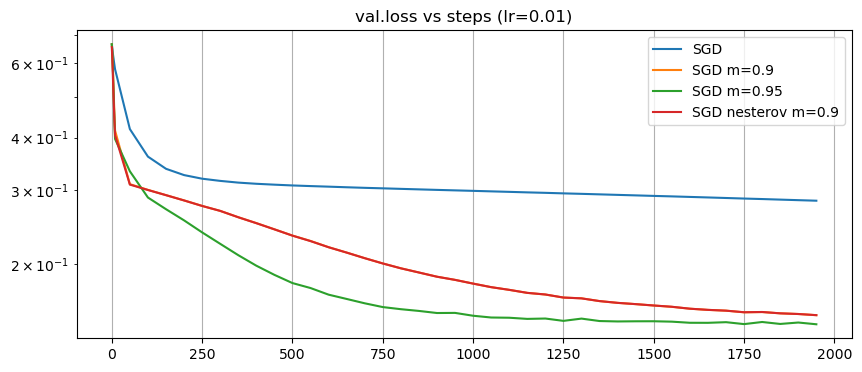

In [7]:
plt.figure(figsize=(10,4))
plt.plot(h_sgd["step"], h_sgd["val.acc"], label="SGD")
plt.plot(h_m09["step"], h_m09["val.acc"], label="SGD m=0.9")
plt.plot(h_m95["step"], h_m95["val.acc"], label="SGD m=0.95")
plt.plot(h_nes["step"], h_nes["val.acc"], label="SGD nesterov m=0.9")
plt.grid(True)
plt.legend()
plt.title(f"val.acc vs steps (lr={lr:g})")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(h_sgd["step"], h_sgd["val.loss"], label="SGD")
plt.plot(h_m09["step"], h_m09["val.loss"], label="SGD m=0.9")
plt.plot(h_m95["step"], h_m95["val.loss"], label="SGD m=0.95")
plt.plot(h_nes["step"], h_nes["val.loss"], label="SGD nesterov m=0.9")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.title(f"val.loss vs steps (lr={lr:g})")
plt.show()


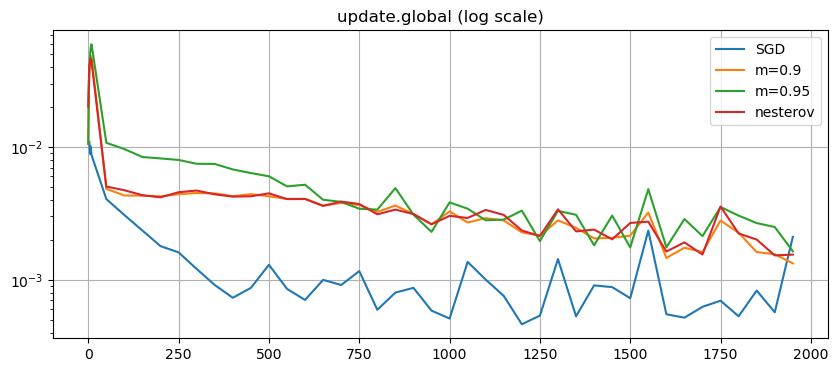

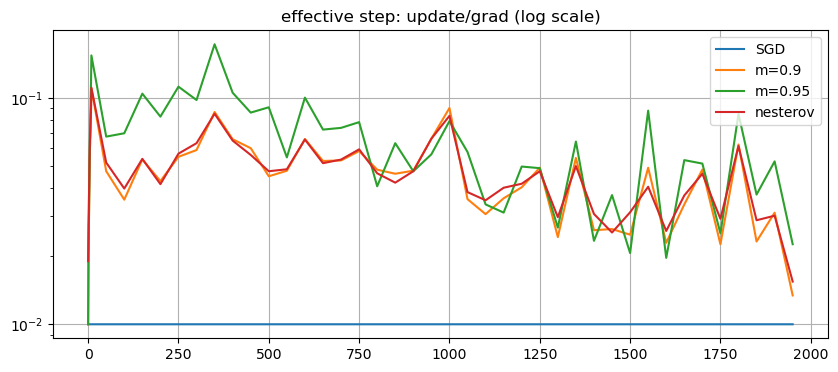

In [8]:
def plot_norms(hist, label):
    steps = hist["step"]
    grad = np.array(hist["grad.global"], dtype=float)
    upd = np.array(hist["update.global"], dtype=float)
    par = np.array(hist["param.global"], dtype=float)
    eff = upd / (grad + 1e-12)
    return steps, grad, upd, par, eff

plt.figure(figsize=(10,4))
for h, label in [(h_sgd,"SGD"), (h_m09,"m=0.9"), (h_m95,"m=0.95"), (h_nes,"nesterov")]:
    steps, grad, upd, par, eff = plot_norms(h, label)
    plt.plot(steps, upd, label=label)
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.title("update.global (log scale)")
plt.show()

plt.figure(figsize=(10,4))
for h, label in [(h_sgd,"SGD"), (h_m09,"m=0.9"), (h_m95,"m=0.95"), (h_nes,"nesterov")]:
    steps, grad, upd, par, eff = plot_norms(h, label)
    plt.plot(steps, eff, label=label)
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.title("effective step: update/grad (log scale)")
plt.show()


При фиксированном lr=0.01 добавление momentum(0.9–0.95) существенно повышает validation accuracy и снижает validation loss по сравнению с чистым SGD. Логи показывают, что это связано с ростом эффективного шага: для SGD он ~ lr и стабилен, а для momentum-методов значительно выше и меняется во времени из-за накопления скорости градиента. Nesterov даёт сопоставимый эффект, иногда с более ровной динамикой.